# Kostnadsoverslag closed source LLMs

Data om kostnader og benchmarks er hentet fra: https://www.vellum.ai/llm-leaderboard

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

notebook_path = Path.cwd()
function_path = Path('functions')
os.chdir(function_path)
from cost_model import make_df_cost, calculate_total_cost
from plot_funcs import plot_multiple_lines
os.chdir(notebook_path)

# Import and merge together
kost = pd.read_csv("kostnader.csv")
bench = pd.read_csv("llm_benchmarks.csv")

df = (
    pd.merge(kost, bench, on=["Modell"], how="left", validate=None)
    .set_index("Modell")
    .drop("Total", axis=1)
)

df.head()


,Context Window,Input Cost / 1M tokens,Output Cost / 1M tokens,Snitt,MMLU (flervalg spm),HellaSwag (reasoning),HumanEval (Python),GSM-8k (lett matematikk),MATH (vanskelig matematikk)
Modell,,,,,,,,,
Claude 2,100K,8.00,24.00,NaN,NaN,NaN,NaN,NaN,NaN
Claude 2.1,200K,8.00,24.00,NaN,NaN,NaN,NaN,NaN,NaN
Claude 3 Haiku,200K,0.25,1.25,73.08,75.2,85.9,75.9,88.9,38.9
Claude 3 Opus,200K,15.00,75.00,84.83,86.8,95.4,84.9,95.0,60.1
Claude 3 Sonnet,200K,3.00,15.00,76.55,79.0,89.0,73.0,92.3,43.1


In [2]:
# Clan str signs in numerical data
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].str.replace('K', '').astype(float)

# Set models column til index for operasjon under
df = df.reset_index()
df.columns = df.columns.str.lower()

df

,modell,context window,input cost / 1m tokens,output cost / 1m tokens,snitt,mmlu (flervalg spm),hellaswag (reasoning),humaneval (python),gsm-8k (lett matematikk),math (vanskelig matematikk)
0,Claude 2,100.0,8.000,24.000,NaN,NaN,NaN,NaN,NaN,NaN
1,Claude 2.1,200.0,8.000,24.000,NaN,NaN,NaN,NaN,NaN,NaN
2,Claude 3 Haiku,200.0,0.250,1.250,73.08,75.2,85.9,75.9,88.90,38.9
3,Claude 3 Opus,200.0,15.000,75.000,84.83,86.8,95.4,84.9,95.00,60.1
4,Claude 3 Sonnet,200.0,3.000,15.000,76.55,79.0,89.0,73.0,92.30,43.1
5,Claude Instant,100.0,0.800,2.400,NaN,NaN,NaN,NaN,NaN,NaN
6,Gemini 1.5 Pro,128.0,7.000,21.000,80.08,81.9,92.5,71.9,91.70,58.5
7,Gemini Pro,32.0,0.125,0.375,68.28,71.8,84.7,67.7,77.90,32.6
8,GPT-3.5 Turbo,16.0,0.500,1.500,NaN,NaN,NaN,NaN,NaN,NaN
9,GPT-3.5 Turbo Instruct,4.0,1.500,2.000,NaN,NaN,NaN,NaN,NaN,NaN


 ## Lag kost / benchmark plot

## Scenario analyse med kjøpte modeller og bruk av API-tilgang

Analysen antar:
- 800 ansatte
- De sender mellom 50 og 350 requests per dag (inkl. automatiserte prosesser som gjør requests) til modellenes API
- 50 ord og 350 ord per spørsmål
- 100 til 600 ord per svar
- 1.33 tokens per ord

Spesielt requests antas å være konservativt da et automatisert program som gjør klassifisering eller datainnhenting kan medføre mange fler requests.
Spørsmålslengden er også svært konservativ da konteksten fra selv enkle RAG modeller gjør at man potensielt får mye lengre spørsmål enn 350 ord (spesielt hvis man prøver å oppsummere dokumentasjon). Tokens per ord kan også variere med hvilken embedder-modell som brukes og hvilket språk man sender spørsmål på.

In [9]:

# Parametre for modellen
employees = np.arange(1, 801, 1)
calls = np.arange(50, 350, 50)
avg_words_per_q = np.arange(50, 350, 50)
avg_words_per_a = np.arange (100, 700, 100)
tokens_per_word = np.array((1.33))

# Dra ut subset columns med modellkostnader til bruk i modell
df_llms = df[['modell', 'context window', 'input cost / 1m tokens','output cost / 1m tokens']].copy()
df_llms.loc[:, 'context window'] = df_llms.loc[:, 'context window'] * 1000

In [10]:
# Lager en stor df med enhetskostnader knyttet til parametre i modellen
df_cost = make_df_cost(employees, calls, avg_words_per_q, avg_words_per_a, tokens_per_word)
    

In [11]:
# Vis dataframe
df_cost

,employees,calls,avg_words_per_q,avg_words_per_a,tokens_per_word,m_tokens_sent,m_tokens_received
0,1.0,50.0,50.0,100.0,1.33,0.003325,0.00665
1,1.0,100.0,50.0,100.0,1.33,0.006650,0.01330
2,1.0,150.0,50.0,100.0,1.33,0.009975,0.01995
3,1.0,200.0,50.0,100.0,1.33,0.013300,0.02660
4,1.0,250.0,50.0,100.0,1.33,0.016625,0.03325
...,...,...,...,...,...,...,...
172795,800.0,100.0,300.0,600.0,1.33,31.920000,63.84000
172796,800.0,150.0,300.0,600.0,1.33,47.880000,95.76000
172797,800.0,200.0,300.0,600.0,1.33,63.840000,127.68000
172798,800.0,250.0,300.0,600.0,1.33,79.800000,159.60000


In [12]:
cost_sent = 'input cost / 1m tokens'
cost_rec = 'output cost / 1m tokens'
models = ['Gemini 1.5 Pro', 'GPT-4', 'Mistral Large', 'Claude 3 Opus']

# Kalkuler totale kostnader
total_cost = calculate_total_cost(df_cost, df_llms, models, cost_sent, cost_rec)


In [13]:
# Make totals columns for tokens
total_cost['m_tokens_total'] = total_cost.loc[:, 'm_tokens_sent'] + total_cost.loc[:, 'm_tokens_received']

In [14]:
# Check largest combinations
total_cost.loc[total_cost['m_tokens_total'] >= 90]

,employees,calls,avg_words_per_q,avg_words_per_a,tokens_per_word,m_tokens_sent,m_tokens_received,Question cost Gemini 1.5 Pro (USD),Answer cost Gemini 1.5 Pro (USD),Total cost Gemini 1.5 Pro (USD),Question cost GPT-4 (USD),Answer cost GPT-4 (USD),Total cost GPT-4 (USD),Question cost Mistral Large (USD),Answer cost Mistral Large (USD),Total cost Mistral Large (USD),Question cost Claude 3 Opus (USD),Answer cost Claude 3 Opus (USD),Total cost Claude 3 Opus (USD),m_tokens_total
18911,752.0,300.0,200.0,100.0,1.33,60.0096,30.0048,420.0672,630.1008,1050.1680,1800.288,1800.288,3600.576,480.0768,720.1152,1200.192,900.144,2250.3600,3150.5040,90.0144
18917,753.0,300.0,200.0,100.0,1.33,60.0894,30.0447,420.6258,630.9387,1051.5645,1802.682,1802.682,3605.364,480.7152,721.0728,1201.788,901.341,2253.3525,3154.6935,90.1341
18923,754.0,300.0,200.0,100.0,1.33,60.1692,30.0846,421.1844,631.7766,1052.9610,1805.076,1805.076,3610.152,481.3536,722.0304,1203.384,902.538,2256.3450,3158.8830,90.2538
18929,755.0,300.0,200.0,100.0,1.33,60.2490,30.1245,421.7430,632.6145,1054.3575,1807.470,1807.470,3614.940,481.9920,722.9880,1204.980,903.735,2259.3375,3163.0725,90.3735
18935,756.0,300.0,200.0,100.0,1.33,60.3288,30.1644,422.3016,633.4524,1055.7540,1809.864,1809.864,3619.728,482.6304,723.9456,1206.576,904.932,2262.3300,3167.2620,90.4932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172795,800.0,100.0,300.0,600.0,1.33,31.9200,63.8400,223.4400,1340.6400,1564.0800,957.600,3830.400,4788.000,255.3600,1532.1600,1787.520,478.800,4788.0000,5266.8000,95.7600
172796,800.0,150.0,300.0,600.0,1.33,47.8800,95.7600,335.1600,2010.9600,2346.1200,1436.400,5745.600,7182.000,383.0400,2298.2400,2681.280,718.200,7182.0000,7900.2000,143.6400
172797,800.0,200.0,300.0,600.0,1.33,63.8400,127.6800,446.8800,2681.2800,3128.1600,1915.200,7660.800,9576.000,510.7200,3064.3200,3575.040,957.600,9576.0000,10533.6000,191.5200
172798,800.0,250.0,300.0,600.0,1.33,79.8000,159.6000,558.6000,3351.6000,3910.2000,2394.000,9576.000,11970.000,638.4000,3830.4000,4468.800,1197.000,11970.0000,13167.0000,239.4000


## Plotting av resultater

In [20]:
total_cost.rolling(1000).mean()

,employees,calls,avg_words_per_q,avg_words_per_a,tokens_per_word,m_tokens_sent,m_tokens_received,Question cost Gemini 1.5 Pro (USD),Answer cost Gemini 1.5 Pro (USD),Total cost Gemini 1.5 Pro (USD),Question cost GPT-4 (USD),Answer cost GPT-4 (USD),Total cost GPT-4 (USD),Question cost Mistral Large (USD),Answer cost Mistral Large (USD),Total cost Mistral Large (USD),Question cost Claude 3 Opus (USD),Answer cost Claude 3 Opus (USD),Total cost Claude 3 Opus (USD),m_tokens_total
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172795,716.500,175.0,300.0,600.0,1.33,50.016286,100.032572,350.114001,2100.684008,2450.798009,1500.488577,6001.954308,7502.442885,400.130287,2400.781723,2800.912010,750.244289,7502.442885,8252.687174,150.048858
172796,716.667,174.9,300.0,600.0,1.33,50.001024,100.002048,350.007169,2100.043014,2450.050183,1500.030724,6000.122898,7500.153622,400.008193,2400.049159,2800.057352,750.015362,7500.153622,8250.168985,150.003072
172797,716.834,174.8,300.0,600.0,1.33,49.989094,99.978188,349.923658,2099.541950,2449.465608,1499.672821,5998.691286,7498.364107,399.912752,2399.476514,2799.389267,749.836411,7498.364107,8248.200518,149.967282
172798,717.000,175.0,300.0,600.0,1.33,50.056246,100.112492,350.393720,2102.362322,2452.756042,1501.687372,6006.749490,7508.436862,400.449966,2402.699796,2803.149762,750.843686,7508.436862,8259.280549,150.168737


e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

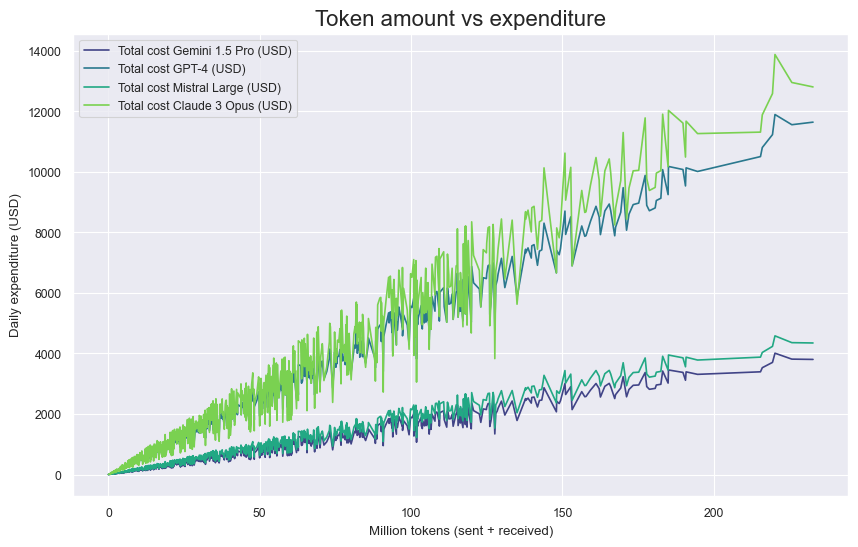

In [34]:
# Will produce noisy figure, hence sampling is necessary
fig1 = plot_multiple_lines(total_cost.sample(1000), 
               'm_tokens_total',
               total_cost.columns[total_cost.columns.str.contains('Total cost')],
               title='Token amount vs expenditure',
               xaxis_title='Million tokens (sent + received)',
               yaxis_title='Daily expenditure (USD)')

fig1.savefig('plots/tokens_vs_cost.png')
            

e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

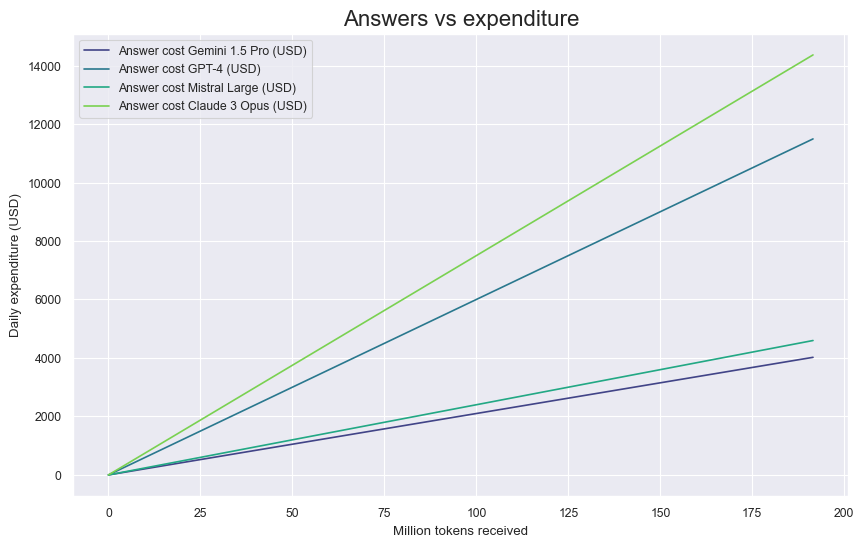

In [16]:
fig2 = plot_multiple_lines(total_cost.sort_values('m_tokens_received'), 
               'm_tokens_received', 
               total_cost.columns[total_cost.columns.str.contains('Answer cost')],
               title='Answers vs expenditure',
               xaxis_title='Million tokens received',
               yaxis_title='Daily expenditure (USD)')


fig2.savefig('plots/received_tokens_vs_expenditure.png')

e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\envs\general-development\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

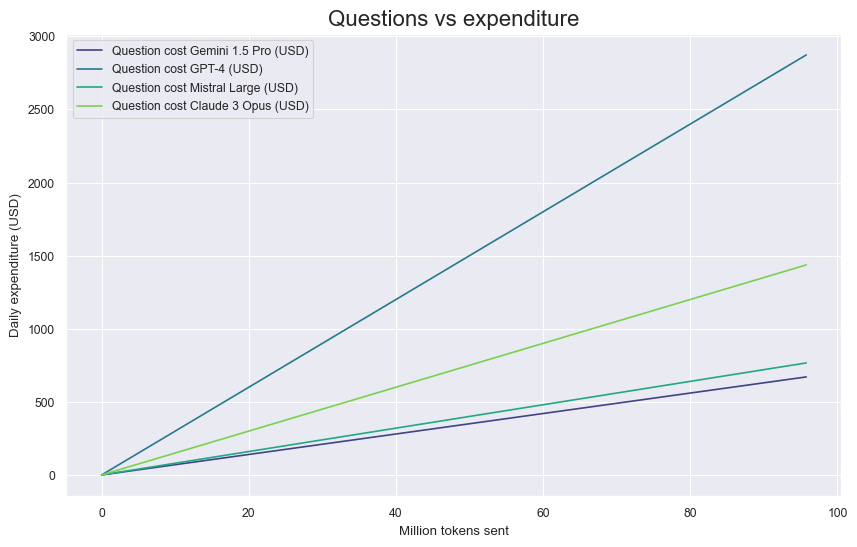

In [17]:
fig3 = plot_multiple_lines(total_cost.sort_values('m_tokens_sent'), 
               'm_tokens_sent', 
               total_cost.columns[total_cost.columns.str.contains('Question cost')],
               title='Questions vs expenditure',
               xaxis_title='Million tokens sent',
               yaxis_title='Daily expenditure (USD)')


fig3.savefig('plots/tokens_sent_vs_expenditure.png')

## Ekport av relevante datasett

In [23]:
# Kolonner til eksporterte datasett
cols_avg_word_per_a = [
    "avg_words_per_a",
    "avg_words_per_q",
    "calls",
    "m_tokens_total",
    "Total cost Gemini 1.5 Pro (USD)",
    "Total cost GPT-4 (USD)",
]

cols_n_calls = [
    "avg_words_per_a",
    "avg_words_per_q",
    "calls",
    "m_tokens_total",
    "Total cost Gemini 1.5 Pro (USD)",
    "Total cost GPT-4 (USD)",
]

# Lag filtreringsmasker
emp_mask = (total_cost['employees'] == 800)
words_per_a_mask = ((total_cost["avg_words_per_a"] >= 100) | (total_cost["avg_words_per_a"] <= 200) & emp_mask)
n_calls_mask = ((total_cost["calls"] == 50) & emp_mask)

# Sensitivitet mtp mengde requests og antall ord per svar, send til datafil for bruk i ppt
total_cost.loc[words_per_a_mask, cols_avg_word_per_a].to_excel(
    "eksporterte_data/kostnad_ord_per_svar.xlsx"
)
total_cost.loc[n_calls_mask, cols_n_calls].to_excel(
    "eksporterte_data/kostnad_calls.xlsx"
)

# Skriv heile shiten til disk, liker ikke excel men la gå
total_cost.to_parquet("eksporterte_data/totale_kostnadsberegninger.parquet")